# Superlative Cities

### Outline

1. Find cities with most and least severe car accidents
2. Feature Analysis for each city
    - Identify most important and most common weather features
    - Identify most important and most common infrastructure features
    (using random forests?)
3. Plots for each city
    - Show where accidents occur and how severe they are on top of a city map kind of
    - Histograms of accident severity for most common condition per weather feature
    - Histogram of accident severity per infrastructure type side by side per city

### Questions:
- How do I pick which subset of cities to analyze for accident severity?
    - currently doing top 10% freq and then analyzing
    - should I look at variance to determine which cities are viable or something?
- Could clustering be helpful to identify accident hotspots?
- Hypothesis: less variance in location for more dangerous cities related to highways and such
    - How to test this: clean out city lat and longs for places that aren't in the main cluster, then compute variance for accident locations over all the cities and see if it is correlate to mean severity

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('US_Accidents_March23.csv')

In [9]:
from matplotlib import pyplot as plt

### Data cleaning

In [6]:
drop_columns = ['ID', 'Source', 'Start_Time', 'End_Time', 
                 'End_Lat', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
                 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 
                 'Amenity', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

df = data.drop(drop_columns, axis=1)

### Identify Cities

In [13]:
def identify_cities(
    df,
    k=1,
    min_samples=1000,
):
    """
    Returns:
        most_dangerous: list of city names (length <= k)
        least_dangerous: list of city names (length <= k)
    Based on empirical-Bayes shrunken severe-crash probabilities.
    """
    df = df.copy()
    
    # define severe indicator: severity >= 3
    df['severe'] = (df['Severity'] >= 3).astype(int)

    # aggregate per city: S_i (k_i), n_i
    agg = df.groupby('City').agg(
        k=('severe', 'sum'),   # number of severe crashes
        n=('severe', 'size')   # total crashes
    )

    # filter by minimum crash count
    agg = agg[agg['n'] >= min_samples]
    if agg.empty:
        raise ValueError("No cities meet the minimum sample requirement.")

    # ----- Empirical Bayes Beta prior from the data -----

    # Global severe rate across included cities
    total_k = agg['k'].sum()
    total_n = agg['n'].sum()
    mu_hat = total_k / total_n  # overall severe probability

    # Prior strength m = median number of crashes per city
    m = agg['n'].median()

    # Beta prior parameters: p ~ Beta(alpha, beta)
    alpha = mu_hat * m
    beta = (1 - mu_hat) * m

    # Posterior parameters for each city:
    # p_city | data ~ Beta(alpha + k_i, beta + n_i - k_i)
    agg['alpha_post'] = alpha + agg['k']
    agg['beta_post'] = beta + agg['n'] - agg['k']

    # MAP estimate for each city:
    # p_hat_EB = (alpha_post - 1) / (alpha_post + beta_post - 2)
    # add a tiny epsilon for numerical safety
    eps = 1e-9
    agg['p_hat_EB'] = (
        (agg['alpha_post'] - 1 + eps) /
        (agg['alpha_post'] + agg['beta_post'] - 2 + 2 * eps)
    )

    # (Optional alternative) posterior mean instead of MAP:
    # agg['p_hat_EB'] = agg['alpha_post'] / (agg['alpha_post'] + agg['beta_post'])

    # ----- Rank cities by shrunken probabilities -----

    most_dangerous = (
        agg.sort_values('p_hat_EB', ascending=False)
           .head(k)
           .index
           .tolist()
    )

    least_dangerous = (
        agg.sort_values('p_hat_EB', ascending=True)
           .head(k)
           .index
           .tolist()
    )

    return most_dangerous, least_dangerous

print(identify_cities(df))

(['Saint Louis'], ['Fresno'])


### Dangerous Cities

Text(0.5, 1.0, 'Accidents in Fresno, most dangerous city')

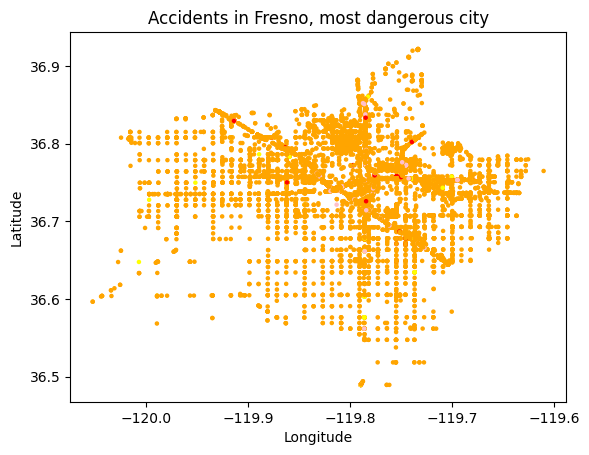

In [ ]:
df_danger1 = df.groupby("City").get_group("Fresno")
df_danger = df_danger1[df_danger1["Start_Lng"] <= -110]   # data cleaning can be adjusted
lat = df_danger["Start_Lat"]
long = df_danger["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_danger['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in Fresno, least dangerous city")


Text(0.5, 1.0, 'Accidents in St Louis most dangerous city')

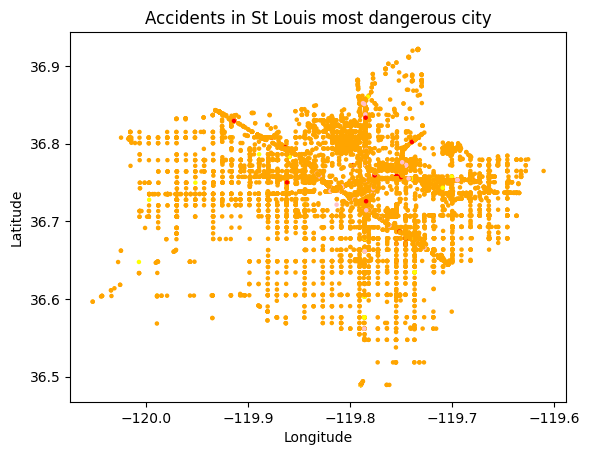

In [20]:
df_danger = df.groupby("City").get_group("Saint Louis")
df_danger = df_danger1[df_danger1["Start_Lng"] <= -115]   # data cleaning can be adjusted
lat = df_danger["Start_Lat"]
long = df_danger["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_danger['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in St Louis most dangerous city")


### Safest Cities

Text(0.5, 1.0, 'Accidents in Abington area 1, safest city')

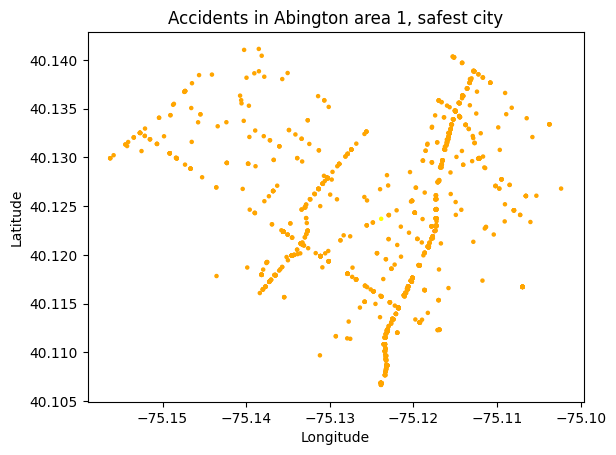

In [13]:
df_safe1 = df.groupby("City").get_group(safe)
df_safe = df_safe1[df_safe1["Start_Lng"] <= -73]   # data cleaning can be adjusted
lat = df_safe["Start_Lat"]
long = df_safe["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_safe['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {safe} area 1, safest city")

Text(0.5, 1.0, 'Accidents in Abington area 2, safest city')

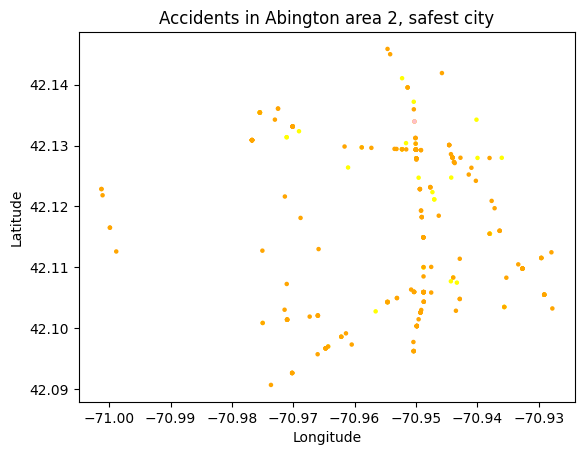

In [14]:
df_safe1 = df.groupby("City").get_group(safe)
df_safe = df_safe1[df_safe1["Start_Lng"] >= -73]   # data cleaning can be adjusted
lat = df_safe["Start_Lat"]
long = df_safe["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_safe['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {safe} area 2, safest city")

Text(0.5, 1.0, 'Accidents in Tucson, Second safest city')

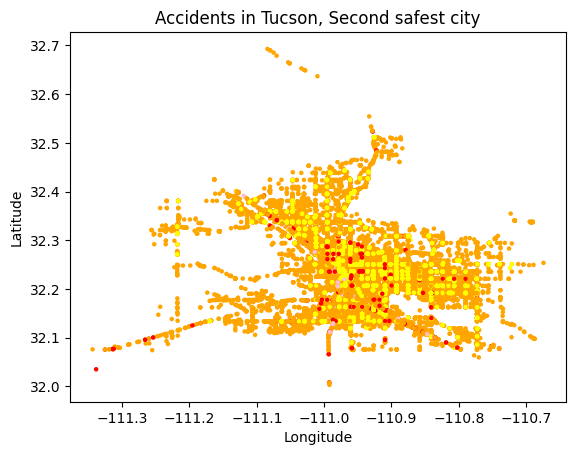

In [15]:
# Let's try a different city
city_counts = df['City'].value_counts()

big_cities = city_counts[city_counts >= 1000].index # cities with >1000 accidents
df_top = df[df["City"].isin(big_cities)]    # those rows in the dataframe

mean_sev = df_top.groupby("City")["Severity"].mean()
second_safest = mean_sev.nsmallest(2).index[1]

df_ss1 = df.groupby("City").get_group(second_safest)
df_ss = df_ss1[df_ss1["Start_Lat"] >= 31.8]   # data cleaning can be adjusted
lat = df_ss["Start_Lat"]
long = df_ss["Start_Lng"]

color_map = {1: "yellow", 2:"orange", 3:"pink", 4:"red"}
colors = df_ss['Severity'].map(color_map)

plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in {second_safest}, Second safest city")